In [1]:
import json
import os
import pickle
import random
import sys
import pickle
import jraph
import tqdm

from typing import Callable, Dict, List, Optional
import haiku as hk
import ase
import ase.io
import jax
import jax.numpy as jnp
import numpy as np
import optax
import yaml

import matplotlib.pyplot as plt

from functools import partial

import sys
import os
# Get the current script's directory
#current_dir = os.getcwd()
# Get the parent directory by going one level up
#parent_dir = os.path.dirname(current_dir)
# Add the parent directory to sys.path
#sys.path.append(parent_dir)


from phonax.datasets import datasets
from phonax.utils import (
    create_directory_with_random_name,
    compute_avg_num_neighbors,
)
from phonax.data_utils import (
    get_atomic_number_table_from_zs,
    compute_average_E0s,
)
from phonax.predictors import predict_energy_forces_stress
from phonax.optimizer import optimizer
from phonax.energy_force_train import energy_force_train
from phonax.loss import WeightedEnergyFrocesStressLoss


from phonax.trained_models import NequIP_JAXMD_molecule_model

from phonax.phonons import (
    atoms_to_ext_graph,
    predict_molecular_spectra_unfilter,
)

from posym import SymmetryNormalModes

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_debug_infs", True)
np.set_printoptions(precision=3, suppress=True)

# Molecular symmetry analysis for IR / Raman active modes

In this tutorial, we demonstrate how to perform symmetry analysis for vibrational modes of the molecules and determine the IR / Raman active modes.
We use CH$_4$ molecule as the example (as used in the book on group theory, application to the physics of condensed matter, by M. Dresselhaus, G. Dresselhaus and A. Jorio.)


## Pre-trained NequIP energy model for molecules

We we load the pre-trained NequIP model for molecules.
This energy model is trained with energy and force data selected from universal IAP dataset which contain only H, C, N, O and F elements that are common for organic molecules. The DFT calculations are done with the PBE exchange-correlation functionals.
This simplified model is used to discuss the symmetry analysis for IR / Raman active modes, and the model can be improved by more advanced DFT (hybrid functional) or quantum chemistry methods (such as CCSD).


In [2]:
model_fn, params, num_message_passing, r_max= NequIP_JAXMD_molecule_model(os.path.join(os.getcwd(), 'trained-models'))


Create NequIP (JAX-MD version) with parameters {'use_sc': True, 'graph_net_steps': 2, 'hidden_irreps': '96x0e+ 96x0o  + 64x1e +64x1o +64x2e +64x2o', 'nonlinearities': {'e': 'swish', 'o': 'tanh'}, 'r_max': 5.0, 'avg_num_neighbors': 53.2808396682792, 'avg_r_min': None, 'num_species': 100, 'radial_basis': <function bessel_basis at 0x7fd0775145e0>, 'radial_envelope': <function soft_envelope at 0x7fd077514540>}


Next, we load the molecular graph data and compute the molecular vibrational modes and spectrum

In [3]:
mol_atoms = ase.io.read('data/molecules/CH4-symmetry.vasp')

mol_graph = atoms_to_ext_graph(mol_atoms, r_max, num_message_passing=1)
mol_masses = ase.data.atomic_masses[mol_graph.nodes.species][mol_graph.nodes.mask_primitive]
gamma_eigs, gamma_vecs, D_gamma = predict_molecular_spectra_unfilter(params, model_fn,mol_graph,mol_masses)

print('Molecular vibration mode energies (in cm^-1):')
# in cm^-1
gamma_eigs


Molecular vibration mode energies (in cm^-1):


Array([  -0.17 ,    0.061,    0.279,    8.22 ,    8.23 ,    8.232,
       1246.004, 1246.01 , 1342.545, 1342.547, 1342.55 , 3277.403,
       3277.416, 3277.425, 3305.425], dtype=float32)

## Molecular point group symmetry

Now we can use posym tool to figure out the molecular point group symmetry.

https://github.com/abelcarreras/posym


To be confirmed: the output Continuous symmetry measures (CSM) probes the amount of symmetry break with respect to a point group symmetry? We should select the point group (highest symmetry) with small measure?
Any other more direct way to get the point group symmetry? (pymatgen might have a relevant tool for this, but needs to figure out how to convert the molecular structure object.)

Response from Abel Carreras confirms this:

Using Posym, indeed you can also determine the symmetry point group a molecule belongs by computing the CSM
and looking for the group that gives a value close to zero. However, in general this requires to analyze
all the possible groups one by one which can be quite inefficient compared to other methods.

Also yes, you will find zero CMS value for all subgroups (since the molecule belongs to all of them),
then is your criteria to choose the highest symmetry group among them. The advantage of using posym
in this case is that you have a clear measure (the CSM) that you can use as a criteria to determine if the
molecule belongs or not to the group given a certain tolerance (concept of quasi-symmetry).

There are many ways (and software) to determine the point group.
Usually they are based in the determination of the principal axis of inertia to reduce rule out
different symmetry groups and then looking for specific symmetry operations to restrict the
search until the group is found. Very similar to the usual scheme that you can find in chemistry books.

Below, we can also use another method from his repository:

https://github.com/abelcarreras/pointgroup



Regarding the proper citation(s) for his work:

At this moment I don’t have any paper specific to this library. That’s why I created a citable zenodo
repository:

https://zenodo.org/record/7261326

Here I list some papers related to the methodology employed in this library:

Pinsky M, Dryzun C, Casanova D, Alemany P, Avnir D, J Comput Chem. 29:2712-21 (2008) 
Pinsky M, Casanova D, Alemany P, Alvarez S, Avnir D, Dryzun C, Kizner Z, Sterkin A. J Comput Chem. 29:190-7 (2008)
Casanova D, Alemany P. Phys Chem Chem Phys. 12(47):15523–9 (2010)
Casanova D, Alemany P, Falceto A, Carreras A, Alvarez S. J Comput Chem 34(15):1321–31 (2013)
A. Carreras, E. Bernuz, X. Marugan, M. Llunell, P. Alemany, Chem. Eur. J. 25, 673 – 691 (2019) 




In [4]:
from posym import SymmetryMolecule

pos_CM = mol_atoms.get_center_of_mass()

coordinates = mol_atoms.get_positions() - pos_CM

#coordinates = np.array([[0.0,0.0,0.0],


symbols = mol_atoms.get_chemical_symbols()

sym_geom = SymmetryMolecule(group='Td', coordinates=coordinates, symbols=symbols)
print('Symmetry measure Td : ', sym_geom.measure)


# C3v as a subgroup of D6h, the measure will be small as well.
sym_geom = SymmetryMolecule(group='C3v', coordinates=coordinates, symbols=symbols)
print('Symmetry measure C3v : ', sym_geom.measure)

sym_geom = SymmetryMolecule(group='C4v', coordinates=coordinates, symbols=symbols)
print('Symmetry measure C4v : ', sym_geom.measure)

# this is our symmetry for the benzene
sym_geom = SymmetryMolecule(group='D6h', coordinates=coordinates, symbols=symbols)
print('Symmetry measure D6h : ', sym_geom.measure)

Symmetry measure Td :  4.3256913606626313e-07
Symmetry measure C3v :  4.022350230670213e-08
Symmetry measure C4v :  10.86539664434758
Symmetry measure D6h :  24.602044733638294


Alternatively, we can use the pointgroup library by the same author of the library, and we confirm a CH$_4$ molecule has a Td point group symmetry.

In [5]:
from pointgroup import PointGroup

pos_CM = mol_atoms.get_center_of_mass()

coordinates = mol_atoms.get_positions() - pos_CM

symbols = mol_atoms.get_chemical_symbols()

pg = PointGroup(positions=coordinates, 
                symbols=symbols)

print('Point group: ', pg.get_point_group())



Point group:  Td


## Translational / Rotational mode projections

In the following, I would like to show how one can perform the mode projections to filter out the pure traslational / rotational modes (with respect to the center of mass)

Note with the point group symmetry analysis above, the translational modes would carry the vector like symmetry irreducible symmetry representations (irreps), while the rotational modes would be of the anti-symmetric second rank tensor type irreps. These will be relevant later for the IR / Raman active mode analysis.

In [6]:
# here we would like to project out the translation + rotation modes by defining the projector

# function to orthogonalize the modes we select
def vector_gram_schmidt(vecs_in):
    vecs_out = []
    for vec in vecs_in:
        if len(vecs_out) == 0:
            vecs_out.append(vec/jnp.linalg.norm(vec))
        else:
            for vec_proj in vecs_out:
                vec -= jnp.sum(vec*vec_proj) *vec_proj
            vecs_out.append(vec/jnp.linalg.norm(vec))
    return vecs_out

num_atoms = len(mol_atoms)

mol_cm = mol_atoms.get_center_of_mass()
shift_pos = mol_atoms.get_positions() - mol_cm

# write down the mode vector, note the subtle sqrt(mass) factor here!
tr_mode1 = jnp.zeros((num_atoms,3))
tr_mode1 = tr_mode1.at[:,0].add(1.0) * jnp.sqrt(mol_masses)[:,None]
tr_mode2 = jnp.zeros((num_atoms,3))
tr_mode2 = tr_mode2.at[:,1].add(1.0)* jnp.sqrt(mol_masses)[:,None]
tr_mode3 = jnp.zeros((num_atoms,3))
tr_mode3 = tr_mode3.at[:,2].add(1.0)* jnp.sqrt(mol_masses)[:,None]


tr_mode1 /= jnp.linalg.norm(tr_mode1)
tr_mode2 /= jnp.linalg.norm(tr_mode2)
tr_mode3 /= jnp.linalg.norm(tr_mode3)

[tr_mode1,tr_mode2,tr_mode3] = vector_gram_schmidt([tr_mode1,tr_mode2,tr_mode3])

x_axis = jnp.array([1.0,0.0,0.0])
y_axis = jnp.array([0.0,1.0,0.0])
z_axis = jnp.array([0.0,0.0,1.0])

rot_mode1 = jnp.cross(x_axis, shift_pos) * jnp.sqrt(mol_masses)[:,None]
rot_mode1 /= jnp.linalg.norm(rot_mode1)
rot_mode2 = jnp.cross(y_axis, shift_pos) * jnp.sqrt(mol_masses)[:,None]
rot_mode2 /= jnp.linalg.norm(rot_mode2)
rot_mode3 = jnp.cross(z_axis, shift_pos) * jnp.sqrt(mol_masses)[:,None]
rot_mode3 /= jnp.linalg.norm(rot_mode3)

[rot_mode1,rot_mode2,rot_mode3] = vector_gram_schmidt([rot_mode1,rot_mode2,rot_mode3])


proj_modes = [tr_mode1,tr_mode2,tr_mode3,rot_mode1,rot_mode2,rot_mode3]


proj_mat = jnp.zeros((3*num_atoms, 3*num_atoms))
for pmode in proj_modes:
    pmode = pmode.reshape(-1)
    proj_mat += jnp.einsum('i,j->ij',pmode,pmode)
    
gamma_proj_norm = []

for gamma_vec in gamma_vecs.T:
    proj_vec = proj_mat @ gamma_vec.real
    gamma_proj_norm.append(jnp.linalg.norm(proj_vec).item())
    
gamma_proj_norm = np.array(gamma_proj_norm) **2

With the total 6 modes for translations and rotations, we can compute the projection weight of these states in the molecular vibrational spectrum. With the projection weight distribution, we find these modes are concentrated at the lowest $E \sim 0$ zero energy modes.

Text(0, 0.5, 'projected norm')

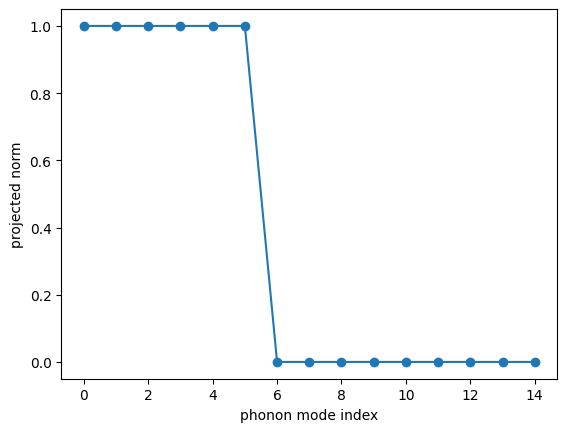

In [7]:
plt.plot(gamma_proj_norm)
plt.scatter(x=np.arange(len(gamma_proj_norm)),y=gamma_proj_norm)
plt.xlabel('phonon mode index')
plt.ylabel('projected norm')


With the external library to perform symmetry analysis, we can determine the vibrational mode symmetry irrep as below:

In [8]:
# In this example, they are translational modes, which transform as (x,y,z)
test_modes = np.array(gamma_vecs.T[:3].real)
test_modes = test_modes.reshape(3,5,3)

sym_modes_gs = SymmetryNormalModes(group='Td', coordinates=coordinates, modes=test_modes, symbols=symbols)
print('Symmetry irrep: ', sym_modes_gs)

Symmetry irrep:  T2


In [9]:
# In this example, they are rotational modes, which transform as (Rx,Ry,Rz)
test_modes = np.array(gamma_vecs.T[3:6].real)
test_modes = test_modes.reshape(3,5,3)

sym_modes_gs = SymmetryNormalModes(group='Td', coordinates=coordinates, modes=test_modes, symbols=symbols)
print('Symmetry irrep: ', sym_modes_gs)

Symmetry irrep:  T1


In [10]:
# one can check any (degenerate) mode(s) to find their symmetry irrep
test_modes = np.array(gamma_vecs.T[6:8].real)
test_modes = test_modes.reshape(2,5,3)

sym_modes_gs = SymmetryNormalModes(group='Td', coordinates=coordinates, modes=test_modes, symbols=symbols)
print('Symmetry irrep: ', sym_modes_gs)

Symmetry irrep:  E


## IR / Raman activity

The point group symmetry imposes constraints of the IR / Raman active modes.
We fwllow the symmetry arguments in the group theory book relevant for the IR / Raman transitions with phonons.
In short summary, the IR modes would transform as vectors, while the Raman modes would transform as symmetric second rank tensors.
In the following, we will implement these symmetry selection rules:



In [11]:
from posym import SymmetryNormalModes

from pointgroup import PointGroup

pos_CM = mol_atoms.get_center_of_mass()

coordinates = mol_atoms.get_positions() - pos_CM

symbols = mol_atoms.get_chemical_symbols()

pg = PointGroup(positions=coordinates, 
                symbols=symbols)


print('Molecular point group: ',pg.get_point_group())

tran_modes_all = [tr_mode1,tr_mode2,tr_mode3]
sym_modes_trans = SymmetryNormalModes(group=pg.get_point_group(), coordinates=coordinates, modes=tran_modes_all, symbols=symbols)


print('Translation mode irreps: ',sym_modes_trans)


rot_modes_all = np.array([rot_mode1,rot_mode2,rot_mode3])

sym_modes_gs_rot = SymmetryNormalModes(group=pg.get_point_group(), coordinates=coordinates, modes=rot_modes_all, symbols=symbols)
print('Rotational mode irreps: ',sym_modes_gs_rot)



Molecular point group:  Td
Translation mode irreps:  T2
Rotational mode irreps:  T1


Because of the symmetry selection rules, the active modes:

IR active modes: They will transform as vector irreps found in the translational modes at zero energy.

Raman active modes: Since they transform as symmetric second rank tensors, we derive the symmetry irreps by finding the irreps for the second rank tensor first (square of the vector irreps), then removing the anti-symmetric component (derived in the rotational modes)


In [13]:
set_pg = pg.get_point_group()


print('point group: ',set_pg)

def decomp_irreps(sym_irreps):
    ir_rep = np.dot(sym_irreps._pg.trans_matrix_inv, sym_irreps.get_reduced_op_representation().values)
    index=sym_irreps._pg.ir_labels
    in_irreps = []
    for ir_, idx_label in zip(ir_rep,index):
        if ir_ > 0.5:
            in_irreps.append(idx_label)
    return in_irreps
            
    
trans_irs = decomp_irreps(sym_modes_trans)

total_r2_irreps = None

from posym import PointGroup, SymmetryObject

for ir1_ in trans_irs:
    ir1 = SymmetryObject(group=set_pg, rep=ir1_)
    for ir2_ in trans_irs:
        ir2 = SymmetryObject(group=set_pg, rep=ir2_)

        if total_r2_irreps is None:
            total_r2_irreps = ir1 * ir2
        else:
            total_r2_irreps = total_r2_irreps + ir1*ir2
            
# now remove the rotational ones:
rot_irs = decomp_irreps(sym_modes_gs_rot)

for ir_ in rot_irs:
    ir = SymmetryObject(group=set_pg, rep=ir_)
    total_r2_irreps = total_r2_irreps + (-1*ir)
    
print('IR active modes: ',sym_modes_trans)
print('Raman active modes: ',total_r2_irreps)

point group:  Td
IR active modes:  T2
Raman active modes:  A1 + E + T2


## Summary


